In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import trange

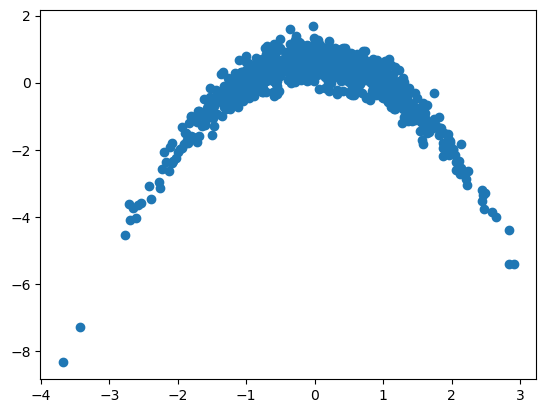

In [2]:
# target distribution q_D
N = 1000
Xs = np.random.randn(2 * N).reshape(N, 2)
Xs[:, 1] -= 2 * Xs[:, 0] ** 2
# it is always a good idea for diffusion to normalize data to zero mean, unit variance
Xs = (Xs - np.mean(Xs, axis=0).reshape(1, -1)) / np.std(Xs, axis=0).reshape(1, -1)
plt.figure()
plt.scatter(Xs[:, 0], Xs[:, 1])
plt.show()

In [3]:
# neural network to learn epsilon(x_t,t). you can play around with it, but we added it for convenience
# note that this networks expects normalized values of t in 0 to 1. so divide your time index by T.
class Net(nn.Module):
    def __init__(self, num_latent_features=32, num_embedding_features=16):
        super().__init__()
        self.num_embedding_features = num_embedding_features
        self.num_latent_features = num_latent_features
        self.fc_in = nn.Linear(2, num_latent_features)
        self.fc_emb = nn.Linear(num_embedding_features, num_latent_features)
        self.fc1 = nn.Linear(num_latent_features, num_latent_features)
        self.fc2 = nn.Linear(num_latent_features, num_latent_features)
        self.fc_out = nn.Linear(num_latent_features, 2)

    def embedding(self, t):
        # We assume that t is an n-dimensional vector with values in [0,1]
        # each element in t gives the time for each element in the batch
        num_frequencies = self.num_embedding_features // 2
        frequencies = torch.logspace(
            0, 3, num_frequencies, device=t.device, dtype=t.dtype
        )
        cos_feats = torch.cos(2 * np.pi * frequencies.unsqueeze(0) * t.unsqueeze(1))
        sin_feats = torch.sin(2 * np.pi * frequencies.unsqueeze(0) * t.unsqueeze(1))
        return torch.hstack([cos_feats, sin_feats])

    def forward(self, x, t):
        # Create sinusoidal features and apply the silu activation
        t_embedding = torch.nn.functional.silu(self.embedding(t))

        # linear combination of space and time features
        x = F.silu(self.fc_in(x) + self.fc_emb(t_embedding))
        # now apply a simple feed forward network with relu activations.
        # note: we skip dropout for simplicity.
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        # transform back
        x = self.fc_out(x)
        return x

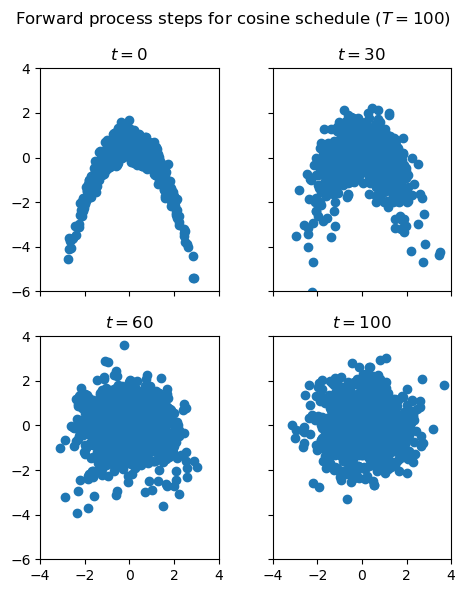

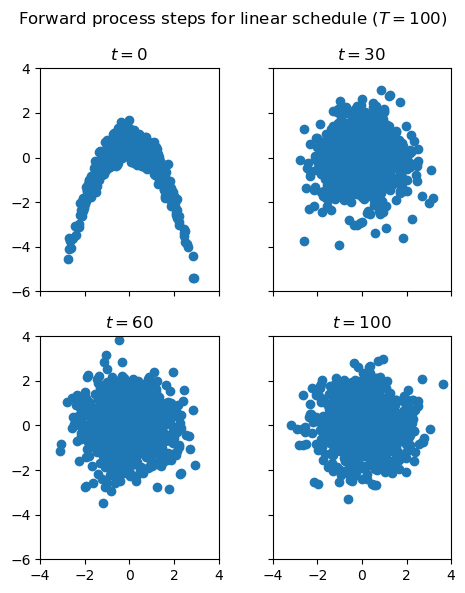

In [17]:
# Task 1: for the given set of T and beta plot the generating distribution q(X_t) for different t=0,30,60,100
# As beta we use the scheme proposed in the lecture
T: int = 100
_ts = torch.linspace(0, 1, T + 1)
_s = 0.08
_gs = torch.cos(torch.pi / 2 * ((_ts + _s) / (1 + _s))) ** 2
betas = torch.minimum(1 - _gs[1:] / _gs[:-1], torch.tensor(0.999))


def gen_xts(xs: torch.Tensor, ts: torch.Tensor, bs: torch.Tensor = betas):
    xs, ts = torch.asarray(xs), torch.asarray(ts).flatten()
    alphas = torch.concat((torch.ones(1), torch.cumprod(1 - bs, 0)))[ts].unsqueeze(1)
    noise = torch.normal(0, 1, size=xs.shape)
    return noise, torch.asarray(
        torch.sqrt(alphas) * xs + torch.sqrt(1 - alphas) * noise, dtype=torch.float32
    )


def plot_datapoints(ax: plt.Axes, xs: torch.Tensor, title: str = "", label: str = ""):
    ax.scatter(xs[:, 0], xs[:, 1], label=label)
    ax.set(
        title=title,
        xlim=(-4, 4),
        ylim=(-6, 4),
        aspect="equal",
    )


for sched_bs, sched_name in ((betas, "cosine"), (0.05 * torch.ones(T), "linear")):
    _, axss = plt.subplots(
        2, 2, tight_layout=True, sharey=True, sharex=True, figsize=(5, 6)
    )
    plt.suptitle(f"Forward process steps for {sched_name} schedule ($T=100$)")
    torch.manual_seed(0)
    for cur_ax, timestep in zip(axss.flat, (0, 30, 60, 100)):
        _noise, test_xts = gen_xts(Xs, timestep, bs=sched_bs)
        plot_datapoints(cur_ax, test_xts, title=f"$t={timestep}$")
plt.show()

In [20]:
# Task 2: implement the loss function for gradient descent (eq 76 in th script, or L_simple in the background material)
# implement by sampling a random time step t in 0,..,T
# params:
#    Xs: a batch of samples from the dataset.
#    model: the model for learning epsilon.
def loss(
    xs: torch.Tensor,
    model_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    bs: torch.Tensor = betas,
):
    sample_ts = torch.randint(0, T + 1, size=(xs.shape[0],))
    noise, xts = gen_xts(xs, sample_ts, bs=bs)
    pred_noise = model_fn(xts, torch.asarray(sample_ts / T, dtype=torch.float32))
    return torch.sum((noise - pred_noise) ** 2)

  0%|          | 0/500 [00:00<?, ?epochs/s]

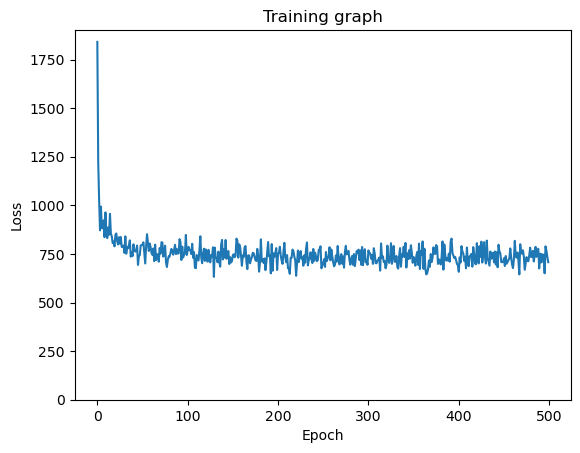

In [26]:
# train loop. added for your convenience.
torch.manual_seed(1)
train_loader = torch.utils.data.DataLoader(
    torch.asarray(Xs, dtype=torch.float32), batch_size=200
)
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.train()
num_epochs = 500
bar = trange(num_epochs, unit="epochs")
epoch_losses = []
for _epoch in bar:
    epoch_loss = 0
    for xs_batch in train_loader:
        optimizer.zero_grad()
        lss = loss(xs_batch, model)
        lss.backward()
        optimizer.step()
        epoch_loss += lss.detach().item()
    epoch_losses.append(epoch_loss)
    bar.set_postfix({"loss": epoch_loss}, refresh=False)

_, training_ax = plt.subplots()
training_ax.plot(epoch_losses)
training_ax.set(xlabel="Epoch", ylabel="Loss", title="Training graph", ylim=(0, None))
plt.show()

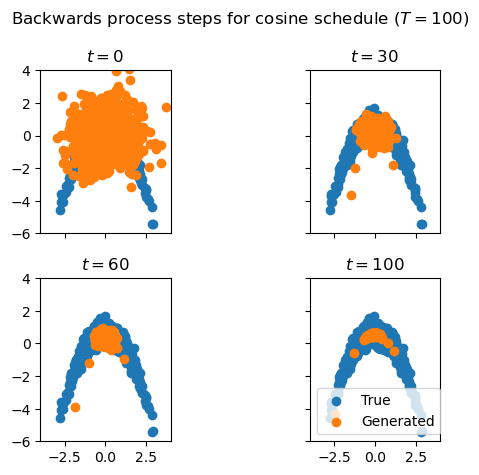

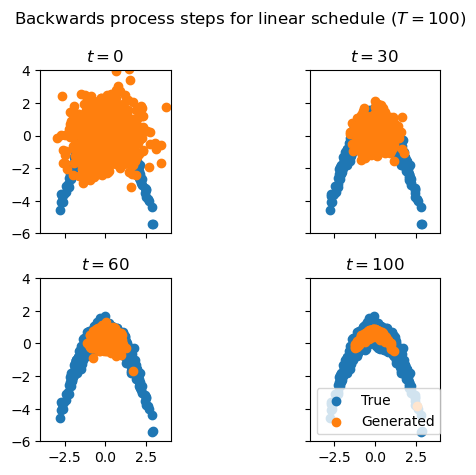

In [27]:
# Task 3: generate samples from the learned model
# num: number of samples to generate
# model: the trained model
def generate_samples(
    model_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    num_samples: int = 1,
    bs: torch.Tensor = betas,
    steps: int = T,
    seed: int = 0,
):
    torch.manual_seed(seed)
    assert 0 <= steps <= T
    with torch.no_grad():
        bs = torch.concat((torch.zeros(1), bs))
        alphas = torch.cumprod(1 - bs, 0)
        xts = torch.normal(0, 1, size=(num_samples, 2))
        for t in range(T, T - steps, -1):
            noise = torch.normal(0, 1, size=xts.shape) if t else torch.zeros_like(xts)
            pred_noise = model_fn(xts, torch.asarray(t / T).flatten())
            # print(xts, pred_noise)
            bt, at = bs[t], alphas[t]
            # print(xts - pred_noise * bt / torch.sqrt(1 - at))
            xts = (xts - pred_noise * bt / torch.sqrt(1 - at)) / torch.sqrt(
                1 - bt
            ) + bt * noise

        return xts


for sched_bs, sched_name in ((betas, "cosine"), (0.05 * torch.ones(T), "linear")):
    _, axss = plt.subplots(2, 2, tight_layout=True, sharey=True, sharex=True)
    plt.suptitle(f"Backwards process steps for {sched_name} schedule ($T=100$)")
    for cur_ax, timestep in zip(axss.flat, (0, 30, 60, 100)):
        samples = generate_samples(model, len(Xs), bs=sched_bs, steps=timestep)
        plot_datapoints(cur_ax, Xs, label="True")
        plot_datapoints(
            cur_ax,
            samples.detach().numpy(),
            label="Generated",
            title=f"$t={timestep}$",
        )
    plt.legend()
    plt.show()